# Dynawo models inspection

In this notebook we analyze the full list of models provided by Dynawo by inspecting the ```ddb``` folder in the used Dynawo's installation folder. We read both ```*.desc.xml``` and ```*.extvar``` files with the method ```dynawo_replay.utils.inspect_model```. The goal of this notebook is to identify which models can be replayed with our infinite bus local replay strategy.

In [ ]:
from dynawo_replay.config import settings
from dynawo_replay.schemas.ext_var import VariableType
from dynawo_replay.utils import (
    inspect_model_extvars,
    infer_core_connection_vars,
    print_dynawo_version,
)

import pandas as pd

print(f"Using Dynawo version {print_dynawo_version()}")

Using Dynawo version 1.7.0 (rev:HEAD-a7ae9af)



In [2]:
all_models = [f.stem for f in settings.DYNAWO_HOME.glob("ddb/*.so")]
print(f"There is a total of {len(all_models)} models in the ddb folder.")

There is a total of 580 models in the ddb folder.


To perform a local replay of an element, it is necessary to connect the element to an infinite bus through voltage and frequency. This requires identifying the connection variables: `terminal_V_re`, `terminal_V_im`, and `omegaRefPu`. While these variables are generally present in all dynamic models, their names can vary. For instance, they may have different prefixes depending on the generator type or include a `_value` suffix, among other variations.

The function `infer_core_connection_vars` in the `dynawo_replay.utils` submodule implements the logic to deduce the names of these variables. Refer to its source code for details on the rules used to infer the connection variable names.

In the next cell, we iterate through all models in the `ddb` folder of the current Dynawo installation. For each model, we attempt to infer the connection variables and record all mandatory external variables that must also be connected. Mandatory external variables are extracted from the model's `*.extvar` file and are identified as those declared with `optional=false` and no default value.

All this data is collected into a pandas DataFrame for further analysis.

In [ ]:
_data = []
for model_name in all_models:
    try:
        ext_vars = inspect_model_extvars(model_name)
    except Exception:
        _data.append(
            {
                "name": model_name,
                "terminal_V_re": None,
                "terminal_V_im": None,
                "omegaRefPu": None,
                "extra_connections": [],
                "noncontinuous_extra_connections": [],
                "ext_vars_file": False,
            }
        )
        continue
    ext_var_names = [v.id.replace(".", "_") for v in ext_vars]
    try:
        omegaRefPu, terminal_V_re, terminal_V_im = infer_core_connection_vars(
            model_name, check_in_list=ext_var_names
        )
    except RuntimeError:
        omegaRefPu, terminal_V_re, terminal_V_im = None, None, None
    extra_connections = [
        v
        for v in ext_vars
        if not v.optional
        and not v.default_value
        and v.id.replace(".", "_") not in (terminal_V_re, terminal_V_im, omegaRefPu)
    ]
    all_extra_connections = [v.id.replace(".", "_") for v in extra_connections]
    noncontinuous_extra_connections = [
        v.id.replace(".", "_")
        for v in extra_connections
        if v.type_value != VariableType.CONTINUOUS
    ]
    _data.append(
        {
            "name": model_name,
            "terminal_V_re": terminal_V_re,
            "terminal_V_im": terminal_V_im,
            "omegaRefPu": omegaRefPu,
            "extra_connections": all_extra_connections,
            "noncontinuous_extra_connections": noncontinuous_extra_connections,
            "ext_vars_file": True,
        }
    )
df = pd.DataFrame(_data)
df

,name,terminal_V_re,terminal_V_im,omegaRefPu,extra_connections,noncontinuous_extra_connections,ext_vars_file
0,HvdcPQPropDiagramPQEmulationSet,None,None,None,"[hvdc_NQ1, hvdc_NQ2, hvdc_terminal1_V_im, hvdc...",[],True
1,GeneratorSynchronousFourWindingsPmConstSt7bPss...,generator_terminal_V_re,generator_terminal_V_im,generator_omegaRefPu_value,[],[],True
2,GeneratorPVRpcl2,None,None,None,"[generator_omegaRefPu_value, generator_termina...","[reactivePowerControlLoop_areaActive_value, re...",True
3,GeneratorSynchronousFourWindingsGoverSt2VREsst...,coupling_terminal1_V_re,coupling_terminal1_V_im,generator_omegaRefPu_value,[governor_PmGtPu],[],True
4,GeneratorSynchronousFourWindingsGoverCc1VREsst...,coupling_terminal1_V_re,coupling_terminal1_V_im,generator_omegaRefPu_value,[],[],True
...,...,...,...,...,...,...,...
575,HvdcPVDanglingRpcl2,None,None,None,"[hvdc_terminal1_V_im, hvdc_terminal1_V_re, hvd...","[reactivePowerControlLoop_areaActive_value, re...",True
576,ElectronicLoad,None,None,None,"[load_terminal_V_im, load_terminal_V_re]",[],True
577,GeneratorSynchronousFourWindingsGoverSiemVRSt6...,coupling_terminal1_V_re,coupling_terminal1_V_im,generator_omegaRefPu_value,[],[],True
578,GeneratorSynchronousFourWindingsGoverDescVRDed...,transformer_terminal1_V_re,transformer_terminal1_V_im,generator_omegaRefPu_value,[],[],True


A model is supported if all `terminal_V_re`, `terminal_V_im` and `omegaRefPu` are succesfully identified by `infer_connection_vars` and there are noncontinuous extra connections (continuous extra connections can be added to the local replay using more `CombiTimeTable` models, but there is currently not a supported way to add noncontinuous connections).

In [4]:
df = pd.DataFrame(_data)
df["supported"] = (
    ~df["terminal_V_re"].isnull()
    & ~df["terminal_V_im"].isnull()
    & ~df["omegaRefPu"].isnull()
    & (df["noncontinuous_extra_connections"].str.len() == 0)
)
df

,name,terminal_V_re,terminal_V_im,omegaRefPu,extra_connections,noncontinuous_extra_connections,ext_vars_file,supported
0,HvdcPQPropDiagramPQEmulationSet,None,None,None,"[hvdc_NQ1, hvdc_NQ2, hvdc_terminal1_V_im, hvdc...",[],True,False
1,GeneratorSynchronousFourWindingsPmConstSt7bPss...,generator_terminal_V_re,generator_terminal_V_im,generator_omegaRefPu_value,[],[],True,True
2,GeneratorPVRpcl2,None,None,None,"[generator_omegaRefPu_value, generator_termina...","[reactivePowerControlLoop_areaActive_value, re...",True,False
3,GeneratorSynchronousFourWindingsGoverSt2VREsst...,coupling_terminal1_V_re,coupling_terminal1_V_im,generator_omegaRefPu_value,[governor_PmGtPu],[],True,True
4,GeneratorSynchronousFourWindingsGoverCc1VREsst...,coupling_terminal1_V_re,coupling_terminal1_V_im,generator_omegaRefPu_value,[],[],True,True
...,...,...,...,...,...,...,...,...
575,HvdcPVDanglingRpcl2,None,None,None,"[hvdc_terminal1_V_im, hvdc_terminal1_V_re, hvd...","[reactivePowerControlLoop_areaActive_value, re...",True,False
576,ElectronicLoad,None,None,None,"[load_terminal_V_im, load_terminal_V_re]",[],True,False
577,GeneratorSynchronousFourWindingsGoverSiemVRSt6...,coupling_terminal1_V_re,coupling_terminal1_V_im,generator_omegaRefPu_value,[],[],True,True
578,GeneratorSynchronousFourWindingsGoverDescVRDed...,transformer_terminal1_V_re,transformer_terminal1_V_im,generator_omegaRefPu_value,[],[],True,True


In [5]:
df["supported"].value_counts()

supported
False    299
True     281
Name: count, dtype: int64

<Axes: xlabel='supported'>

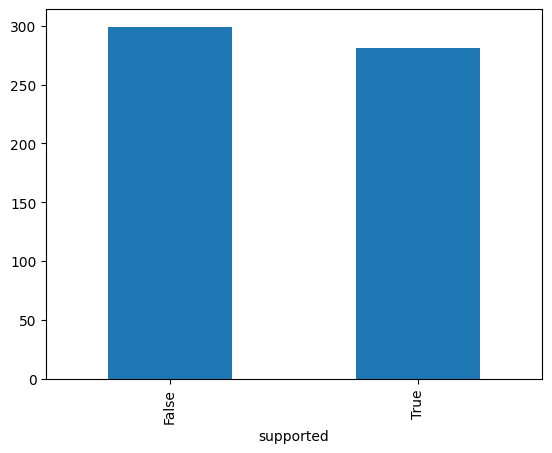

In [6]:
df["supported"].value_counts().plot(kind="bar")

The dataclass `ConnectionVars` in `dynawo_replay.utils` has a method to infer all connection variables through model library. The logic behind this method is the one explained in this notebook.

In [7]:
from dynawo_replay.utils import ConnectionVars

ConnectionVars.from_lib("GeneratorSynchronousFourWindingsProportionalRegulationsUva")

ConnectionVars(omegaRefPu='generator_omegaRefPu_value', terminal_V_re='generator_terminal_V_re', terminal_V_im='generator_terminal_V_im', extra=['underVoltageAutomaton_UMonitoredPu'])

In [8]:
ConnectionVars.from_lib("GeneratorPVRpcl2")

NotSupportedModel: Cannot infer core connection vars

When creating a `ReplayableCase` object, the tool will collect all the dynamic models of the case that use a supported library and keep track of the connection variables needed. These supported dynamic models is what we call `replayable_elements` of the case.